In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import math
import warnings
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
print("Load the training, test and store data using pandas")
features = pd.read_csv("/content/gdrive/My Drive/Walmart/Data/features.csv")
stores = pd.read_csv("/content/gdrive/My Drive/Walmart/Data/stores.csv")
train = pd.read_csv("/content/gdrive/My Drive/Walmart/Data/train.csv")



Load the training, test and store data using pandas


In [0]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_columns', 160)

In [0]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [0]:
stores["Type"].value_counts()

A    22
B    17
C     6
Name: Type, dtype: int64

In [0]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [0]:
print("Join with store")
train = pd.merge(train, stores, on='Store')


Join with store


In [0]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


In [0]:
train.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
dtype: int64

In [0]:

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [0]:
# Gather some features
def build_features(features, data):
    # remove NaNs
    data.fillna(0, inplace=True)
    features.extend(['Store',"Dept", "Size"])

    features.append('IsHoliday')
    data['IsHoliday'] = data['IsHoliday'].astype(float)
    features.append('month')
    features.append('day')
    features.append('year')
    data['year'] = data.Date.apply(lambda x: x.split('-')[0])
    data['year'] = data['year'].astype(float)
    data['month'] = data.Date.apply(lambda x: x.split('-')[1])
    data['month'] = data['month'].astype(float)
    data['day'] = data.Date.apply(lambda x: x.split('-')[2])
    data['day'] = data['day'].astype(float)

    features.append('Type')
    data.loc[data['Type'] == 'A', 'Type'] = '1'
    data.loc[data['Type'] == 'B', 'Type'] = '2'
    data.loc[data['Type'] == 'C', 'Type'] = '3'
    data['Type'] = data['Type'].astype(float)



In [0]:
features = []

print("augment features")
build_features(features, train)
print(features)

augment features
['Store', 'Dept', 'Size', 'IsHoliday', 'month', 'day', 'year', 'Type']


In [0]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,year,month,day
0,1,1,2010-02-05,24924.50,0.0,1.0,151315,2010.0,2.0,5.0
1,1,1,2010-02-12,46039.49,1.0,1.0,151315,2010.0,2.0,12.0
2,1,1,2010-02-19,41595.55,0.0,1.0,151315,2010.0,2.0,19.0
3,1,1,2010-02-26,19403.54,0.0,1.0,151315,2010.0,2.0,26.0
4,1,1,2010-03-05,21827.90,0.0,1.0,151315,2010.0,3.0,5.0


In [0]:
train.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,year,month,day
421565,45,98,2012-09-28,508.37,0.0,2.0,118221,2012.0,9.0,28.0
421566,45,98,2012-10-05,628.10,0.0,2.0,118221,2012.0,10.0,5.0
421567,45,98,2012-10-12,1061.02,0.0,2.0,118221,2012.0,10.0,12.0
421568,45,98,2012-10-19,760.01,0.0,2.0,118221,2012.0,10.0,19.0
421569,45,98,2012-10-26,1076.80,0.0,2.0,118221,2012.0,10.0,26.0


In [0]:
train = train[train.Weekly_Sales > 0]

In [0]:
train.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
year            0
month           0
day             0
dtype: int64

In [0]:
X_train = train[train.Date < '2011-12-01']
X_test = train[train.Date >= '2011-12-01']

In [0]:
X_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,year,month,day
0,1,1,2010-02-05,24924.50,0.0,1.0,151315,2010.0,2.0,5.0
1,1,1,2010-02-12,46039.49,1.0,1.0,151315,2010.0,2.0,12.0
2,1,1,2010-02-19,41595.55,0.0,1.0,151315,2010.0,2.0,19.0
3,1,1,2010-02-26,19403.54,0.0,1.0,151315,2010.0,2.0,26.0
4,1,1,2010-03-05,21827.90,0.0,1.0,151315,2010.0,3.0,5.0


In [0]:
X_train[features].isnull().sum()

Store        0
Dept         0
Size         0
IsHoliday    0
month        0
day          0
year         0
Type         0
dtype: int64

## Training a Model

In [0]:
params = {"objective": "reg:linear",
          "eta": 0.3,
          "max_depth": 8,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 300
print("Train a XGBoost model")
# ytr = np.log(X_train["Weekly_Sales"] + 1).fillna(0)
# yte = np.log(X_test["Weekly_Sales"] + 1).fillna(0)
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["Weekly_Sales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["Weekly_Sales"] + 1))

Train a XGBoost model


In [0]:
type(dtrain)

xgboost.core.DMatrix

In [0]:

watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50,feval=rmspe_xg, verbose_eval=True)

print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['Weekly_Sales'].values)
print('error', error)

[0]	eval-rmse:5.8696	train-rmse:5.88047	eval-rmspe:6.43634	train-rmspe:3.61924
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:4.18997	train-rmse:4.19094	eval-rmspe:15.3859	train-rmspe:8.48349
[2]	eval-rmse:3.08575	train-rmse:3.07694	eval-rmspe:55.0787	train-rmspe:31.765
[3]	eval-rmse:2.2852	train-rmse:2.26387	eval-rmspe:74.4362	train-rmspe:53.0456
[4]	eval-rmse:1.75199	train-rmse:1.71783	eval-rmspe:86.503	train-rmspe:73.3533
[5]	eval-rmse:1.44446	train-rmse:1.39975	eval-rmspe:133.018	train-rmspe:117.509
[6]	eval-rmse:1.26494	train-rmse:1.21319	eval-rmspe:182.685	train-rmspe:164.122
[7]	eval-rmse:1.10742	train-rmse:1.03735	eval-rmspe:174.752	train-rmspe:163.774
[8]	eval-rmse:0.977689	train-rmse:0.902586	eval-rmspe:194.24	train-rmspe:187.389
[9]	eval-rmse:0.945141	train-rmse:0.866308	eval-rmspe:216.743	train-rmspe:212.42
[10]	eval-rmse:0.887312	train-rmse:0.804903	eval-rmspe:

## Validate The Model 

In [0]:

test = pd.read_csv("/content/gdrive/My Drive/Walmart/Data/train.csv")
test.shape

(421570, 5)

In [0]:
test.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [0]:
test = pd.merge(test, stores, on='Store')
features = []
build_features(features, test)
X_test = test[test.Date >= '2012-10-19']
X_test.shape

(5909, 10)

In [0]:
test = X_test[X_test.Store == 1]
test.shape

(143, 10)

In [0]:
test["predict"] = gbm.predict(xgb.DMatrix(test[features]))

In [0]:
measure = math.pow(mean_squared_error(np.exp(test['predict'].values) - 1,test['Weekly_Sales'].values), 0.5)
print("RMSE:", measure)

RMSE: 4298.488997317299


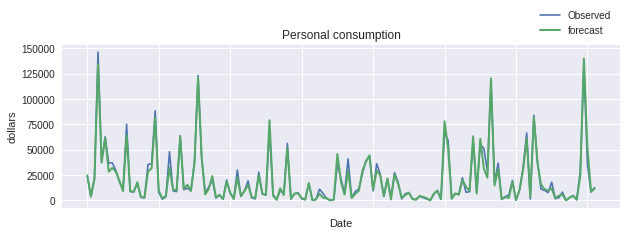

In [0]:
# Dynamic predictions
test.index = test.Date
test = test= test.sort_values("Date")

predict_dy = np.exp(test["predict"])-1

# Graph
fig, ax = plt.subplots(figsize=(10,3))
ax.set(title='Personal consumption', xlabel='Date', ylabel='dollars')


t_start='2012-10-19'
pred_start = '2012-10-19'
t_end='2012-10-26'
test.Weekly_Sales.plot(ax=ax, style='-',linewidth=1.6, label='Observed')
predict_dy.plot(ax=ax,style='-',linewidth=2, label='forecast')
legend = ax.legend(loc='lower right',bbox_to_anchor=(1,1))

In [0]:
train.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,year,month,day
421565,45,98,2012-09-28,508.37,0.0,2.0,118221,2012.0,9.0,28.0
421566,45,98,2012-10-05,628.10,0.0,2.0,118221,2012.0,10.0,5.0
421567,45,98,2012-10-12,1061.02,0.0,2.0,118221,2012.0,10.0,12.0
421568,45,98,2012-10-19,760.01,0.0,2.0,118221,2012.0,10.0,19.0
421569,45,98,2012-10-26,1076.80,0.0,2.0,118221,2012.0,10.0,26.0
